# Find Gini Coefficients of Gene Expression Data
### by Curtis Schunk 9.20.2022

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

## Values to Choose

In [2]:
max_gini_coef=0.5 #Default=0.5 / a lower number will include more genes

manual_selection_of_sections=0 #Leave at zero if you would like the subsection size to be automatically chosen

## Importing Coordinate Data

#### Make sure that the x-values, y-values, and spot names are being read correctly

In [3]:
coords=pd.read_excel('starmap/stm_spatial.xlsx')

In [4]:
x=np.array(coords['x_microns'])
y=np.array(coords['y_microns'])
spot_name=np.array(coords['Unnamed: 0'])

In [5]:
# Make sure that the x-values, y-values, and spot names are being read correctly

## Importing Gene Expression Data

#### Make sure the gene names are being read correctly and that the ge_df is in the correct format

In [6]:
raw_ge_df=pd.read_csv('starmap/starmap_genes.csv')

In [7]:
# Converting Gene Expression DataFrame to Correct Format
# Should be formatted: Gene Names as Column Names, Spot Names as Row Names

ge_df=raw_ge_df.set_index('Unnamed: 0')
#ge_df

In [8]:
genes=ge_df.columns

## Making Rectangular Outline 

In [9]:
x_min=min(x)
x_max=max(x)
y_min=min(y)
y_max=max(y)

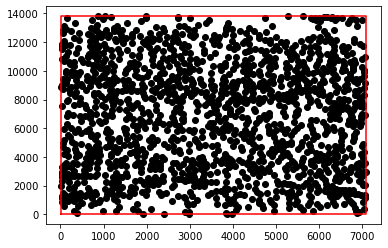

In [10]:
fig,ax = plt.subplots()
ax.scatter(x,y,c='black');
ax.plot([x_min,x_min,x_max,x_max,x_min],[y_min,y_max,y_max,y_min,y_min],c='red');

## Making Subsections

In [11]:
n=len(x)
n_num=math.sqrt(n)

In [12]:
num_of_sections=round(math.sqrt(n_num))

if manual_selection_of_sections!=0:
    num_of_sections=manual_selection_of_sections
    
print('Number of Sections = ',num_of_sections)

Number of Sections =  6


In [13]:
x_len=x_max-x_min
y_len=y_max-y_min
sub_x_size=x_len/num_of_sections
sub_y_size=y_len/num_of_sections

In [14]:
sub_x=list()
sub_y=list()
for i in range(num_of_sections+1):
    sub_x.append(x_min+i*sub_x_size)
    sub_y.append(y_min+i*sub_y_size)

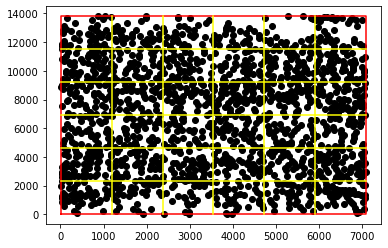

In [15]:
fig,ax = plt.subplots()

ax.scatter(x,y,c='black');
ax.plot([x_min,x_min,x_max,x_max,x_min],[y_min,y_max,y_max,y_min,y_min],c='red');

for i in range(num_of_sections-1):
    i=i+1
    ax.plot([sub_x[i],sub_x[i]],[y_min,y_max],c='yellow')
    ax.plot([x_min,x_max],[sub_y[i],sub_y[i]],c='yellow')

## Assigning Spots to Subsections

In [16]:
subsection=0
sub_assignment=np.zeros(n)
for i in range(num_of_sections):
    for h in range (num_of_sections):
        subsection+=1
        for spot_num in range(n):
            if x[spot_num]>=sub_x[i] and x[spot_num]<=sub_x[i+1] and y[spot_num]>=sub_y[h] and y[spot_num]<=sub_y[h+1]:
                sub_assignment[spot_num]=subsection

In [17]:
sub_assignment=sub_assignment.astype(int)

In [18]:
color_list=list(sns.color_palette('tab20').as_hex()+sns.color_palette('tab20b').as_hex()+sns.color_palette('tab20c').as_hex())

In [19]:
if max(sub_assignment)>60:
    color_list=color_list*math.ceil(max(sub_assignment))

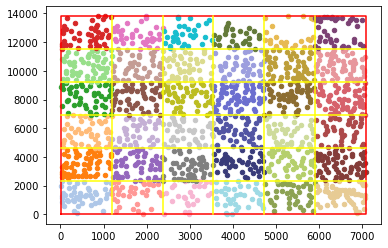

In [20]:
fig,ax = plt.subplots()
group = sub_assignment
color_list=color_list

#Plot Red Outline
ax.plot([x_min,x_min,x_max,x_max,x_min],[y_min,y_max,y_max,y_min,y_min],c='red');

#Plot Yellow Subsections
for i in range(num_of_sections-1):
    i=i+1
    ax.plot([sub_x[i],sub_x[i]],[y_min,y_max],c='yellow')
    ax.plot([x_min,x_max],[sub_y[i],sub_y[i]],c='yellow')

#Plot Spots... Different Subgroup = Different Color
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(x[ix], y[ix], c = [color_list[g]], label = g, s = 20)

## Getting Averages for Each Gene for Each Subsection

In [21]:
ge_df.insert (0, "sub_assignment", sub_assignment)

/Users/curtis/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


In [22]:
sub_array=np.zeros([num_of_sections**2,ge_df.shape[1]])

for i in range(num_of_sections**2):
    i=i+1
    working_sub=ge_df.loc[ge_df['sub_assignment']==i].mean()
    working_sub=np.array(working_sub)
    sub_array[i-1]=working_sub

In [23]:
sub_df=pd.DataFrame(sub_array)

In [24]:
column_titles=list(genes)
column_titles.insert(0,'sub_assignment')
sub_df=sub_df.set_axis([column_titles], axis=1, inplace=False)

In [25]:
#sub_df

## Finding Gini Coefficient

In [26]:
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

# function via: https://planspace.org/2013/06/21/how-to-calculate-gini-coefficient-from-raw-data-in-python/

In [27]:
gini_list=list()
for i in range(len(genes)):
    working_gene=np.array(sub_df[genes[i]])
    gini_obj=gini(working_gene)
    gini_list.append(gini_obj)

In [28]:
ginis=np.array(gini_list)

In [29]:
gini_df=pd.DataFrame([genes,ginis[:,0]]).transpose().set_axis(['Genes','Gini'], axis=1, inplace=False)

In [30]:
sorted_gini_df=gini_df.sort_values(by=['Gini'],ascending=False)

In [31]:
sorted_cut_gini_df=sorted_gini_df[sorted_gini_df.Gini > max_gini_coef]

In [32]:
sorted_cut_gini_df

,Genes,Gini
996,Vip,0.63439
595,Nrip3,0.627481
892,Sst,0.621158
668,Pcp4,0.58492
706,Plp1,0.582184
499,Mbp,0.572649
521,Mobp,0.562992
886,Spink8,0.539392
163,Cnot6l,0.538793
738,Ptgds,0.517549


## Expression Map of Top 4 Spatially Varying Genes

In [33]:
#Making Heatmap

num_of_colors=100
pre_color_list=np.zeros([num_of_colors,3])
for i in range(num_of_colors):
    pre_color_list[i]=[1-i/num_of_colors,1-i/num_of_colors,1-i/num_of_colors]
    
for i in range(num_of_colors):
    if i==0:
        htmp_color_list=[(pre_color_list[i][0],pre_color_list[i][1],pre_color_list[i][2])]
    else:
        htmp_color_list+=[(pre_color_list[i][0],pre_color_list[i][1],pre_color_list[i][2])]

In [34]:
name_1=sorted_cut_gini_df.reset_index().iloc[0][1]
name_2=sorted_cut_gini_df.reset_index().iloc[1][1]
name_3=sorted_cut_gini_df.reset_index().iloc[2][1]
name_4=sorted_cut_gini_df.reset_index().iloc[3][1]

In [35]:
expression_for_gene1=np.array(ge_df[name_1])
expression_for_gene2=np.array(ge_df[name_2])
expression_for_gene3=np.array(ge_df[name_3])
expression_for_gene4=np.array(ge_df[name_4])

In [36]:
heatmap_group_1=((expression_for_gene1/max(expression_for_gene1))*(num_of_colors-1)).astype(int)
heatmap_group_2=((expression_for_gene2/max(expression_for_gene2))*(num_of_colors-1)).astype(int)
heatmap_group_3=((expression_for_gene3/max(expression_for_gene3))*(num_of_colors-1)).astype(int)
heatmap_group_4=((expression_for_gene4/max(expression_for_gene4))*(num_of_colors-1)).astype(int)

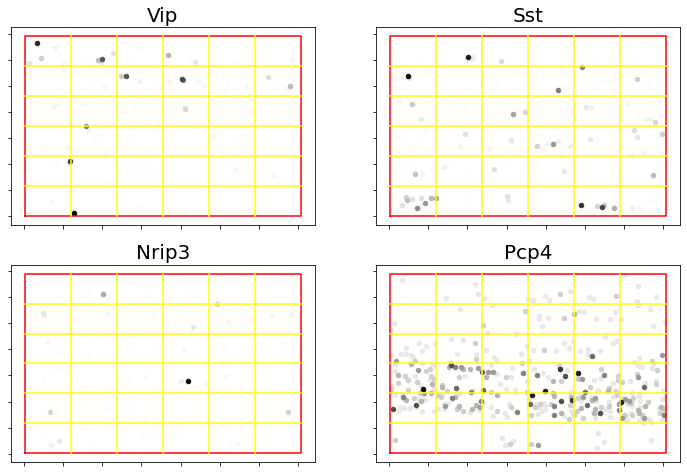

In [37]:
fig,ax = plt.subplots(2,2,figsize=(12, 8))
color_list=htmp_color_list

### Gene 1

group=heatmap_group_1
#Plot Spots... Different Subgroup = Different Color
for g in np.unique(group):
    ix = np.where(group == g)
    ax[0, 0].scatter(x[ix], y[ix], c = [color_list[g]], label = g, s = 20)
    
ax[0, 0].set_title(name_1,size=20)
ax[0, 0].xaxis.set_ticklabels([])
ax[0, 0].yaxis.set_ticklabels([])
    
### Gene 2

group=heatmap_group_2
#Plot Spots... Different Subgroup = Different Color
for g in np.unique(group):
    ix = np.where(group == g)
    ax[1, 0].scatter(x[ix], y[ix], c = [color_list[g]], label = g, s = 20)
    
ax[1, 0].set_title(name_2,size=20)
ax[1, 0].xaxis.set_ticklabels([])
ax[1, 0].yaxis.set_ticklabels([])
    
### Gene 3

group=heatmap_group_3
#Plot Spots... Different Subgroup = Different Color
for g in np.unique(group):
    ix = np.where(group == g)
    ax[0, 1].scatter(x[ix], y[ix], c = [color_list[g]], label = g, s = 20)
    
ax[0, 1].set_title(name_3,size=20)
ax[0, 1].xaxis.set_ticklabels([])
ax[0, 1].yaxis.set_ticklabels([])
      
### Gene 4

group=heatmap_group_4
#Plot Spots... Different Subgroup = Different Color
for g in np.unique(group):
    ix = np.where(group == g)
    ax[1, 1].scatter(x[ix], y[ix], c = [color_list[g]], label = g, s = 20)
    
ax[1, 1].set_title(name_4,size=20)
ax[1, 1].xaxis.set_ticklabels([])
ax[1, 1].yaxis.set_ticklabels([])
    
#Plot Red Outline
ax[0, 0].plot([x_min,x_min,x_max,x_max,x_min],[y_min,y_max,y_max,y_min,y_min],c='red');
ax[1, 0].plot([x_min,x_min,x_max,x_max,x_min],[y_min,y_max,y_max,y_min,y_min],c='red');
ax[0, 1].plot([x_min,x_min,x_max,x_max,x_min],[y_min,y_max,y_max,y_min,y_min],c='red');
ax[1, 1].plot([x_min,x_min,x_max,x_max,x_min],[y_min,y_max,y_max,y_min,y_min],c='red');

#Plot Yellow Subsections
for i in range(num_of_sections-1):
    i=i+1
    ax[0, 0].plot([sub_x[i],sub_x[i]],[y_min,y_max],c='yellow')
    ax[0, 0].plot([x_min,x_max],[sub_y[i],sub_y[i]],c='yellow')
    ax[1, 0].plot([sub_x[i],sub_x[i]],[y_min,y_max],c='yellow')
    ax[1, 0].plot([x_min,x_max],[sub_y[i],sub_y[i]],c='yellow')
    ax[0, 1].plot([sub_x[i],sub_x[i]],[y_min,y_max],c='yellow')
    ax[0, 1].plot([x_min,x_max],[sub_y[i],sub_y[i]],c='yellow')
    ax[1, 1].plot([sub_x[i],sub_x[i]],[y_min,y_max],c='yellow')
    ax[1, 1].plot([x_min,x_max],[sub_y[i],sub_y[i]],c='yellow')

## Single Gene Lookup

In [38]:
gene_looking_at='Plp1'

#### Plotting Gene

In [39]:
expression_for_gene_looking_at=np.array(ge_df[gene_looking_at])

In [40]:
heatmap_groups=((expression_for_gene_looking_at/max(expression_for_gene_looking_at))*(num_of_colors-1)).astype(int)

Genes        Plp1
Gini     0.582184
Name: 706, dtype: object


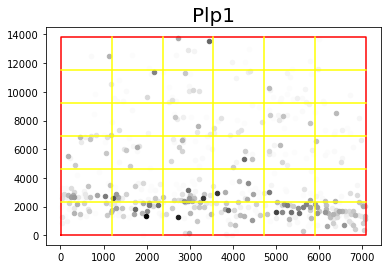

In [41]:
fig,ax = plt.subplots()
group=heatmap_groups
color_list=htmp_color_list

#Plot Spots... Different Subgroup = Different Color
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(x[ix], y[ix], c = [color_list[g]], label = g, s = 20)
    
ax.set_title(gene_looking_at,size=20)
    
#Plot Red Outline
ax.plot([x_min,x_min,x_max,x_max,x_min],[y_min,y_max,y_max,y_min,y_min],c='red');

#Plot Yellow Subsections
for i in range(num_of_sections-1):
    i=i+1
    ax.plot([sub_x[i],sub_x[i]],[y_min,y_max],c='yellow')
    ax.plot([x_min,x_max],[sub_y[i],sub_y[i]],c='yellow')

#Print Gini for Single Gene
print(gini_df.iloc[np.where(genes==gene_looking_at)[0][0]])

## Export List of Spatially Varying Genes

In [42]:
# Including Gini Values
#sorted_cut_gini_df.to_csv('spatially_varying_genes.csv')

# Only Gene Names
#pd.DataFrame(list(sorted_cut_gini_df['Genes'])).to_csv('NamesOnly_spatially_varying_genes.csv',index=None)